In [1]:
#Parameters for the initial maps
nmaps=2             #At least 2
fwhm_min=5         #In arcmin
nside=2048          #2^n

#Parameters for LAMBDA CAMB
cosmo=dict(H0=67.3, ombh2=0.022, omch2=0.120, tau=0.078, omk=0)
inipow=dict(ns=0.966, r=0)
lmax=3*nside-1

#Parameters for the sources
usesources=True
nsources=200
fwhmsources_min=fwhm_min          #in arcmin
Imin=0.                           #minimum intensity of the sources assuming 1 arcmin^2 (in sigmas* 1 arcmin²)
Imax=200.                        #maximum intensity of the sources assuming 1 arcmin^2 (in sigmas* 1 arcmin²)
#angtol_min=2.5*fwhmsources_min   #Angular tolerance to classify a detection as signal (in arcmin)
rho=6.                            #Angular tolerance to classify a detection as signal (in pixels)

#Parameters for the needlets ('alm' method)
B=1.2
j=39                   #Negative to start counting by the end
lmaxneed=lmax          #Set to 2*nside to have beta maps of the same nside that the input

#Parameters for the calculation of pvaluesplotlib
interpolation=True        #True to speed the process using interpolation
step=0.05                 #Step of the x to exactly calculate the pvalues

#Parameter for the multiple testing
alpha=0.01

#Parameters for the visualization
perclist=[0.68,0.9]
nbins=30


folder=f'/home/javier/data/Thesis/simulations'
if usesources:
    folder=folder+f's{nsources}'

In [2]:
%matplotlib notebook

from astropy.io import fits
import healpy as hp
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.special import gamma as gafun
from scipy.stats import norm
import scipy.integrate as integrate
import camb
import os
import shelve
import glob


if not os.path.exists(folder):
    os.makedirs(folder)
    print(f'Creating folder {folder}')

for files in os.listdir(folder):
    if files:
        print(files)
        raise Exception('The folder '+folder+' exists but it is not empty, please remove all files.')


Creating folder /home/javier/data/Thesis/simulationss200


In [3]:
fwhm=fwhm_min*2.*np.pi/(360.*60.)
fwhmsources=fwhmsources_min*2.*np.pi/(360.*60.)
angtol_min=rho*hp.nside2resol(nside,arcmin=True)
angtol=angtol_min*2.*np.pi/(360.*60.)

In [4]:
if usesources:
    (rho*hp.nside2resol(nside,arcmin=True)*2.*np.pi/(360.*60.))**2.*np.pi*nsources

In [5]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(**cosmo, mnu=0.06)
pars.InitPower.set_params(**inipow)
pars.set_for_lmax(lmax, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
totcls=powers['total'][:lmax+1,0]
ls=np.arange(lmax+1)[:len(totcls)]
cls=totcls*2.*np.pi/((ls*(ls+1.)))
cls[0]=0.

gbl = hp.gauss_beam(fwhm, cls.shape[0]-1)
cmbsigma=np.sqrt(np.sum(cls*(2.*ls+1.)/(4.*np.pi)))
cmbsigma_smooth=np.sqrt(np.sum(cls*(2.*ls+1.)*gbl**2./(4.*np.pi)))

print('Sigma is '+str(cmbsigma)+'. \n',
     'Sigma after gaussian beaming is '+str(cmbsigma_smooth)+'.')

Sigma is 107.52317835540966. 
 Sigma after gaussian beaming is 104.60408482938448.


/home/javier/Programas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [6]:
if usesources:
    random_phi = np.random.rand(nsources)*2.0*np.pi
    random_theta = np.arccos(2.*np.random.rand(nsources)-1.0)

    vecsou=hp.ang2vec(random_theta,random_phi)

    pixsou=hp.vec2pix(nside,vecsou[:,0],vecsou[:,1],vecsou[:,2])


In [7]:
if usesources:
    souinten=((np.arange(nsources)/nsources)*(Imax-Imin)+Imin)*cmbsigma_smooth/(hp.nside2pixarea(nside,degrees=True)*3600.)

    sources=np.zeros(hp.nside2npix(nside))
    sources[pixsou]=souinten
    sources=hp.smoothing(sources,fwhm=fwhmsources)
    souintenpost=sources[pixsou]
    
    hp.write_map(folder+'/sources.fits',sources,column_names=['TEMPERATURE'],column_units=['uK'],overwrite=True)

    hp.mollview(sources)

Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>

In [8]:
def blf(l,j,B=1.2):
    u=(l/B**j)
    bl=u**2.*np.exp(-u**2.)
    return(bl)

In [9]:
bl=blf(np.arange(3*nside),j,B=B)

import time
time1=time.time()

    
if usesources:
    sigmabeta=np.zeros(nmaps+1)
    for imap in np.arange(nmaps):
        print(f'Doing map number {imap}')
        mapa=hp.sphtfunc.synfast(cls, nside,fwhm=fwhm)
        hp.write_map(folder+'/map'+str(imap)+'.fits',mapa+sources,column_names=['TEMPERATURE'],column_units=['uK'],overwrite=True)
        
        alm=hp.map2alm(mapa+sources)
        betas=hp.alm2map(hp.almxfl(alm,bl),nside)/np.sqrt(12.*nside**2.)
        sigmabeta[imap]=betas.std()
        hp.write_map(folder+'/beta'+str(imap)+'.fits',betas,column_names=['T_NEEDC_'+str(int(j))],column_units=['uK'],overwrite=True)
        
    nextra=1
    hp.write_map(folder+'/map'+str(nmaps)+'.fits',mapa,column_names=['TEMPERATURE'],column_units=['uK'],overwrite=True)

    alm=hp.map2alm(mapa)
    betas=hp.alm2map(hp.almxfl(alm,bl),nside)/np.sqrt(12.*nside**2.)
    hp.write_map(folder+'/beta'+str(nmaps)+'.fits',betas,column_names=['T_NEEDC_'+str(int(j))],column_units=['uK'],overwrite=True)
    sigmabeta[nmaps]=betas.std()
    
else:
    sigmabeta=np.zeros(nmaps)
    for imap in np.arange(nmaps):
        print(f'Doing map number {imap}')
        mapa=hp.sphtfunc.synfast(cls, nside,fwhm=fwhm)
        hp.write_map(folder+'/map'+str(imap)+'.fits',mapa,column_names=['TEMPERATURE'],column_units=['uK'],overwrite=True)
        
        alm=hp.map2alm(mapa)
        betas=hp.alm2map(hp.almxfl(alm,bl),nside)/np.sqrt(12.*nside**2.)
        sigmabeta[imap]=betas.std()
        hp.write_map(folder+'/beta'+str(imap)+'.fits',betas,column_names=['T_NEEDC_'+str(int(j))],column_units=['uK'],overwrite=True)
        
            
    nextra=0

time2=time.time()
time.strftime("%H:%M:%S", time.gmtime(time2-time1))

Doing map number 0


/home/javier/Programas/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:390: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Doing map number 1
Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


'00:06:21'

In [10]:
print(mapa.std(),'\n',cmbsigma_smooth)    #Check that they are similar

103.90612903700097 
 104.60408482938448


In [11]:
# if usesources:
#     plt.figure()
#     plt.hist(souintenpost,bins=40)

#     np.save(folder+'/vecsou',vecsou)
#     np.save(folder+'/pixsou',pixsou)
    
#     plt.figure()
#     plt.scatter(souinten/cmbsigma_smooth,sources[pixsou]/cmbsigma_smooth)

In [12]:
# plt.figure()
# for jj in np.arange(200):
#     bl=blf(ls,jj,B=B)
#     plt.plot(ls,bl**2., label=jj)
# plt.legend()
# bl=blf(ls,j,B=B)

In [13]:
hp.mollview((betas).flatten(),xsize=3200)

<IPython.core.display.Javascript object>

In [14]:
for imap in np.arange(nmaps+nextra):
    file= open(folder+'/hotspot.par','w')
    file.writelines(['infile='+folder+'/beta'+str(imap)+'.fits \n',
    'extrema_outfile = '+folder+'/pixlminmax'+str(imap)+'.fits \n',
    'maxima_outfile = '+folder+'/maxima'+str(imap)+'.dat \n',
    'minima_outfile = '+folder+'/minima'+str(imap)+'.dat'])
    file.close()
    
    !hotspot {folder}/hotspot.par


Reading run parameters from /home/javier/data/Thesis/simulationss200/hotspot.par
 parameters not defined in that file will be set to their default value
                     HOTSPOTS 3.40
  ***  Finding Maxima and Minima of a HEALPIX Map  ***
  *** (Application of the Neighbour-finding Tools) ***
 
 Parser: infile = /home/javier/data/Thesis/simulationss200/beta0.fits
 
 Parser: extrema_outfile = /home/javier/data/Thesis/simulationss200/pixlminmax0.fits
 
 Parser: maxima_outfile = /home/javier/data/Thesis/simulationss200/maxima0.dat
 
 Parser: minima_outfile = /home/javier/data/Thesis/simulationss200/minima0.dat
 
  HOTSPOTS> Reading /home/javier/data/Thesis/simulationss200/beta0.fits...
 HOTSPOTS> Converting to NESTED numbering scheme.
 Convert: Converting map pixelisation scheme
 HOTSPOTS> Starting extrema search in pixel space.
 Done.
 HOTSPOTS> Converting map back to RING numbering.
 Convert: Converting map pixelisation scheme
 HOTSPOTS> Converting peaks to RING numbering.
 Convert:

In [15]:
maxi=[]
for imap in np.arange(nmaps+nextra):
    maxfile=np.loadtxt(folder+'/maxima'+str(imap)+'.dat')
    maxi.append([maxfile[:,0],maxfile[:,1]/sigmabeta[imap]])


In [16]:
nsidebeta=nside

In [19]:
variables=['alpha','nmaps','fwhm','nside','nsidebeta','cosmo','inipow','lmax','usesources','nsources',
           'fwhmsources','Imin','Imax','angtol','B','j','interpolation','step','perclist','nbins','folder','ls',
           'cls','gbl','cmbsigma','cmbsigma_smooth','nextra','mapa','betas','sigmabeta','maxi']

if usesources:
    variables.extend(['sources','vecsou','pixsou','souinten'])

In [20]:
filename=folder+'/shelf'
my_shelf = shelve.open(filename,'n')      #'n' for new

for key in variables:
    my_shelf[key] = globals()[key]
my_shelf['info']=f'This is a simulation of {nmaps} maps with nside={nside}; fwhm={fwhm} radians ({fwhm_min} arcmin) and lmax={lmax} (which produces beta maps of nside={nsidebeta}) \n The beta map has been calculated for B={B}, j={j} for Mexican Hat Needlets.'
my_shelf['method']=f'alm'
if usesources:
    my_shelf['info']=my_shelf['info']+f'\n {nsources} artificial point sources have been injected into each map with fwhm={fwhmsources} radians. \n Their intensity is between {Imin} and {Imax} sigma'
my_shelf.close()

In [21]:
def getexactks(clsj,ls):
    if len(clsj) != len(ls):
        raise ValueError('clsj and ls must have the same lenght')
    c1=np.sum((2.*ls+1.)*ls*(ls+1.)/(8.*np.pi)*clsj)
    c2=np.sum((2.*ls+1.)*ls*(ls+1.)*(ls-1.)*(ls+2.)/(32.*np.pi)*clsj)
    
    k1=c1/c2
    k2=c1**2./c2
    return(k1,k2)


def getcs(gamma,n,p=1.):
    '''
    Outputs c_{p,2n}(gamma)
    '''
    return(2.**(gamma/2. - 2. - n - 2.*p) * gafun(1.- gamma/2. + n +2.*p))
    

def getks(j,B,gamma,p=1.):
    #Approximation as j goes to infinity
    cp0=getcs(gamma,0.,p)
    cp2=getcs(gamma,1.,p)
    cp4=getcs(gamma,2.,p)
    
    k1=4.*(cp2/cp4)*(B**(-2.*j))
    k2=2.*(cp2)**2./(cp0*cp4)
    return(k1,k2)
    
    
def funf(x,k1,k2):
    fx=((2.*np.sqrt(3.+k1))/(2.+k1*np.sqrt(3.+k1))* 
    ((k1+k2*(x**2.-1.))*norm.pdf(x)*norm.cdf((x*np.sqrt(k2))/(np.sqrt(2+k1-k2))) +
    np.sqrt(k2*(2.+k1-k2))/(2.*np.pi)*x*np.exp((-(2.+k1)*x**2.)/(2.*(2.+k1-k2))) +
    np.sqrt(2./(np.pi*(3.+k1-k2)))*np.exp((-(3.+k1)*x**2.)/(2.*(3.+k1-k2)))*
    norm.cdf((np.sqrt(k2)*x)/np.sqrt((2.+k1-k2)*(3.+k1-k2)))
    ))
    return(fx)


def pval(x,k1,k2):
    result=integrate.quad(funf,x,np.inf, args=(k1,k2))
    return(result)


def percent(perc, cbins, num):
    nbins=len(cbins)
    minmax=np.zeros((2,nbins))
    snum=np.sort(num,axis=0).T
    for ibin in np.arange(nbins):
        minmax[:,ibin]=np.interp([1.-perc,perc],(np.arange(nmaps)+1)/nmaps,snum[ibin])
    return(minmax)


vfunf=np.vectorize(funf)
vpval=np.vectorize(pval)

In [22]:
clsj=hp.sphtfunc.anafast(betas/(sigmabeta[-1]))
lsj=np.arange(len(clsj))

In [23]:
# xt=np.arange(-2,6,0.01)
# k1c,k2c=getexactks(gbl[:a]**2.*cls[:a]/(cmbsigma_smooth**2.),ls[:a])

# ytcmb=vfunf(xt,k1c,k2c)
# ytbeta=vfunf(xt,k1theo,k2theo)

# fig=plt.figure()

# plt.plot(xt,ytcmb, label='CMB map',zorder=2)
# plt.plot(xt,ytbeta, label=r'$\beta$-map',zorder=1)

# ax=plt.gca()
# ax.set_xlabel('Intensity of maxima ($\sigma$)',fontsize=14)
# ax.set_ylabel('Maxima distribution',fontsize=14)
# plt.tight_layout()
# plt.legend()


In [24]:
a=6000

<IPython.core.display.Javascript object>


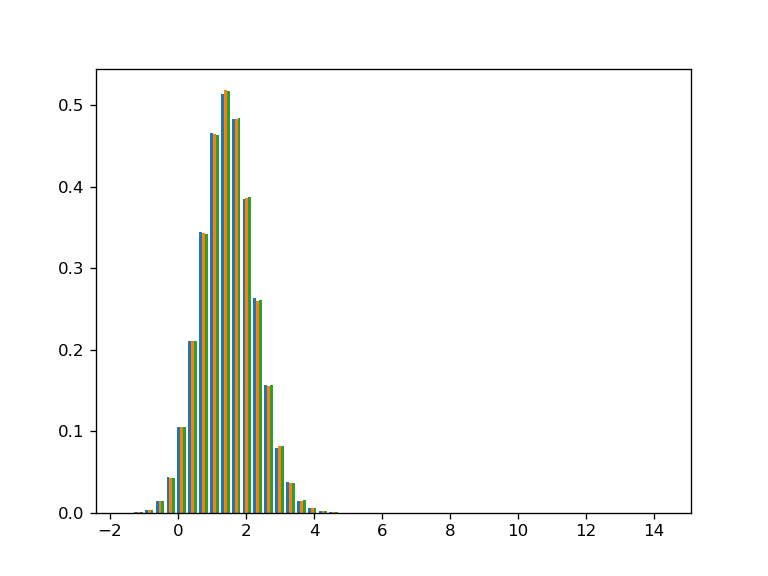

/home/javier/Programas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


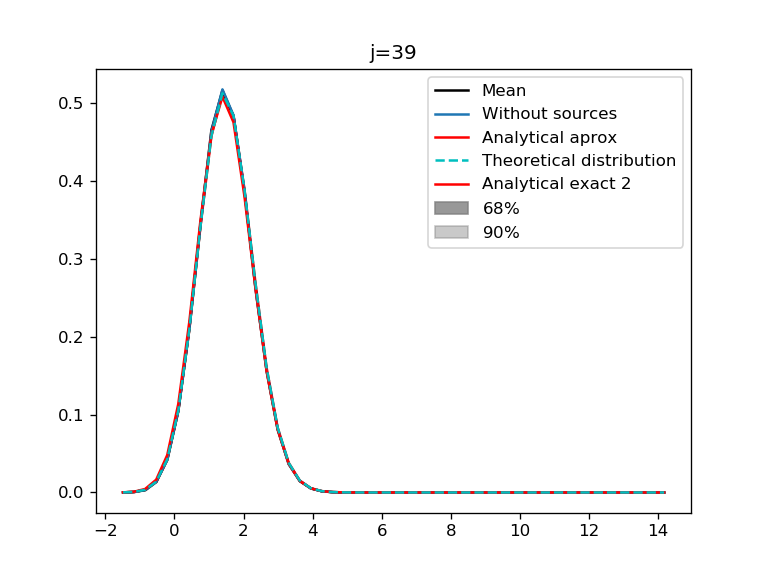

<IPython.core.display.Javascript object>


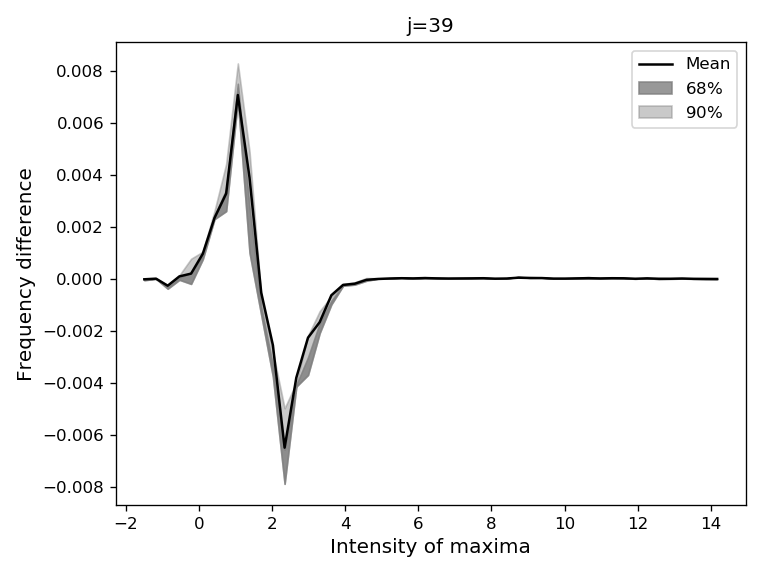

In [28]:
plt.figure()
num,bins,patches=plt.hist(np.array(maxi)[:,1],bins=50,normed=1)

cbins=(bins[:-1]+bins[1:])/2

k1apro,k2apro=getks(gamma=2.5,B=B,j=j)
theo1=vfunf(cbins,k1apro,k2apro)

k1theob,k2theob=getexactks(clsj,lsj)
theo2=vfunf(cbins,k1theob,k2theob)

k1theo,k2theo=getexactks(bl[:a]**2.*gbl[:a]**2.*cls[:a]/(sigmabeta[-1]**2.*(12.*nside**2.)),ls[:a])
theo3=vfunf(cbins,k1theo,k2theo)

plt.figure()
if usesources:
    plt.plot(cbins,np.mean(num[:-1],axis=0), 'k', label='Mean')
    for perc in perclist:
        minmax=percent(perc,cbins,num[:-1])
        plt.fill_between(cbins, minmax[0],minmax[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')
    plt.plot(cbins,num[-1], label='Without sources')
else:
    plt.plot(cbins,np.mean(num,axis=0), 'k', label='Mean')
    for perc in perclist:
        minmax=percent(perc,cbins,num)
        plt.fill_between(cbins, minmax[0],minmax[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')

    
plt.plot(cbins,theo1, 'r', label='Analytical aprox')
plt.plot(cbins,theo2, 'c--', label='Theoretical distribution',zorder=2)
plt.plot(cbins,theo3, 'r', label='Analytical exact 2',zorder=1)
plt.gca().set_title(f'j={int(j)}')



plt.legend()

plt.figure()
plt.plot(cbins,(np.mean(num,axis=0)-theo3), 'k', label='Mean')
for perc in perclist:
    if usesources:
        minmax2=percent(perc,cbins,num[:-1]-theo3)
    else:
        minmax2=percent(perc,cbins,(num-theo3))
    plt.fill_between(cbins, minmax2[0],minmax2[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')

ax=plt.gca()
ax.set_title(f'j={int(j)}')
ax.set_xlabel('Intensity of maxima', fontsize=12)
ax.set_ylabel('Frequency difference', fontsize=12)

plt.legend()
plt.tight_layout()


In [26]:
# fig=plt.figure()
# plt.plot(cbins,(np.mean(num,axis=0)-theo3), 'k', label='Mean')
# for perc in perclist:
#     if usesources:
#         minmax2=percent(perc,cbins,num[:-1]-theo3)
#     else:
#         minmax2=percent(perc,cbins,(num-theo3))
#     plt.fill_between(cbins, minmax2[0],minmax2[1], color='gray', alpha=(2-perc*1.75), label=str(int(perc*100))+'$\%$')

# ax=plt.gca()
# ax.set_xlabel('Intensity of maxima', fontsize=12)
# ax.set_ylabel('Frequency difference', fontsize=12)

# plt.legend()
# plt.tight_layout()

<IPython.core.display.Javascript object>


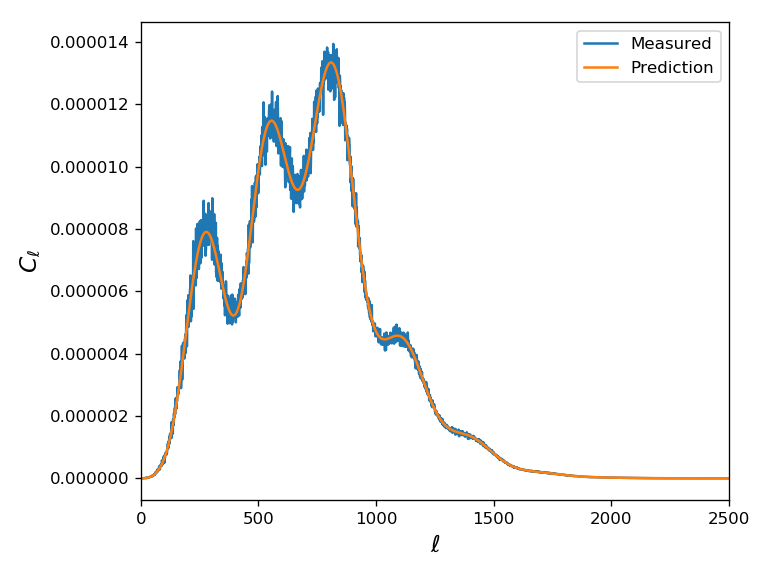

In [32]:
fig=plt.figure()
plt.plot(lsj,clsj,zorder=1, label='Measured')
plt.plot(ls[:a],bl[:a]**2.*gbl[:a]**2.*cls[:a]/(sigmabeta[-1]**2.*12.*nside**2.),zorder=2, label='Prediction')


ax=plt.gca()
ax.set_xlim([0,2500])
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel(r'$C_\ell$',fontsize=14)
plt.tight_layout()
plt.legend()


#Check that they are the same